### Here is contained all data processing code for my master Thesis

In [39]:
import re,os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
# re patterns
pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'received_s: (\d+) received_ns: (\d+)'

# get difference in timespec
def timespec_difference(start_s, start_ns, end_s, end_ns):
    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

- boxplot
- metrics in S
- check consistency of all data

## Retrive data

In [40]:
sequence = [1,2,4,6,8,10,12]
protocols = ["udp"] #, "udpM"] #For now considering only udp

base_dir=os.path.join("data/wildcards/100shotv3/")

sent_data = defaultdict(list)
received_data =defaultdict(list)
sent_data_dummy = []
received_data_dummy = []

for seq in sequence:
    for prots in protocols:
        # Pub part
        file_path= os.path.join(base_dir,f'pubs/pub_{prots}_part+_{seq}.data')
        with open(file_path, 'r') as file: 
                for line in file:
                    match = re.search(pub_pattern, line)
                    if match:
                        cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                        sent_data[seq].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
        # Sub part
        for numb in range(1,seq+1):
            for j in range( int(48 / seq) ):
                file_path= os.path.join(base_dir,f'group{seq}/sub_{prots}_part{numb}_{j}.data')
                with open(file_path, 'r') as file: 
                    for line_n,content in enumerate(file):
                        match = re.search(sub_pattern, content)
                        if match:
                            received_s, received_ns = match.groups()
                            start_s,start_ns = ((sent_data[seq][line_n][2], sent_data[seq][line_n][3]))
                            s_diff, ns_diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns))
                            received_data[seq].append((s_diff, ns_diff))

## Outsider
for prots in protocols:
    file_path= os.path.join(base_dir,f'pubs/pub_{prots}_outsider_0.data')
    with open(file_path, 'r') as file: 
                    for line in file:
                        match = re.search(pub_pattern, line)
                        if match:
                            cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                            sent_data_dummy.append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
    for j in range(48):
        file_path= os.path.join(base_dir,f'groupd/sub_{prots}_outsider_{j}.data')
        with open(file_path, 'r') as file: 
            for line_n,content in enumerate(file):
                match = re.search(sub_pattern, content)
                if match:
                    received_s, received_ns = match.groups()
                    start_s,start_ns = ((sent_data_dummy[line_n][2], sent_data_dummy[line_n][3]))
                    s_diff, ns_diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns))
                    received_data_dummy.append((s_diff, ns_diff))



print(received_data.values())
print(received_data_dummy)

dict_values([[(0, 251859), (0, 133799), (0, 117670), (0, 115563), (0, 116535), (0, 117052), (0, 112185), (0, 111599), (0, 113934), (0, 117685), (0, 116163), (0, 127911), (0, 114419), (0, 115536), (0, 118367), (0, 118223), (0, 119945), (0, 120310), (0, 113524), (0, 117663), (0, 117240), (0, 111012), (0, 113606), (0, 114417), (0, 114474), (0, 113426), (0, 116064), (0, 116417), (0, 110582), (0, 111890), (0, 111062), (0, 113247), (0, 120688), (0, 114298), (0, 112285), (0, 116083), (0, 117576), (0, 117390), (0, 115674), (0, 113406), (0, 116914), (0, 113586), (0, 115447), (0, 111060), (0, 113059), (0, 113768), (0, 119825), (0, 109575), (0, 116431), (0, 112202), (0, 111600), (0, 115451), (0, 115907), (0, 114832), (0, 113980), (0, 114854), (0, 115195), (0, 113244), (0, 115545), (0, 114969), (0, 114130), (0, 115888), (0, 119336), (0, 113768), (0, 111500), (0, 114925), (0, 113555), (0, 113861), (0, 111656), (0, 111902), (0, 113136), (0, 115548), (0, 118984), (0, 112857), (0, 111743), (0, 111374)

## Cleaning data

In [41]:
column_time = {}
column_time_dummy = []

# Convert data to timespec
for ngroup in received_data:
    list_difference=[]
    nlen= len(received_data[ngroup])
    for cycle_data in received_data[ngroup]:
        list_difference.append(cycle_data[0] + cycle_data[1] /1e9) # time in second
    column_time[ngroup]=list_difference
    #column_averages[ngroup
    print(column_time[ngroup])
    
for cycle_data in received_data_dummy:
    column_time_dummy.append( cycle_data[0] + cycle_data[1] / 1e9 )# time in second

# Remove outliers
lower_bound, upper_bound = calculate_iqr(column_time_dummy)
column_time_dummy_cleaned = [x for x in column_time_dummy if lower_bound <= x <= upper_bound]

for ngroup, data in column_time.items():
    lower_bound, upper_bound = calculate_iqr(data)
    column_time[ngroup] = [x for x in data if lower_bound <= x <= upper_bound]

[0.000251859, 0.000133799, 0.00011767, 0.000115563, 0.000116535, 0.000117052, 0.000112185, 0.000111599, 0.000113934, 0.000117685, 0.000116163, 0.000127911, 0.000114419, 0.000115536, 0.000118367, 0.000118223, 0.000119945, 0.00012031, 0.000113524, 0.000117663, 0.00011724, 0.000111012, 0.000113606, 0.000114417, 0.000114474, 0.000113426, 0.000116064, 0.000116417, 0.000110582, 0.00011189, 0.000111062, 0.000113247, 0.000120688, 0.000114298, 0.000112285, 0.000116083, 0.000117576, 0.00011739, 0.000115674, 0.000113406, 0.000116914, 0.000113586, 0.000115447, 0.00011106, 0.000113059, 0.000113768, 0.000119825, 0.000109575, 0.000116431, 0.000112202, 0.0001116, 0.000115451, 0.000115907, 0.000114832, 0.00011398, 0.000114854, 0.000115195, 0.000113244, 0.000115545, 0.000114969, 0.00011413, 0.000115888, 0.000119336, 0.000113768, 0.0001115, 0.000114925, 0.000113555, 0.000113861, 0.000111656, 0.000111902, 0.000113136, 0.000115548, 0.000118984, 0.000112857, 0.000111743, 0.000111374, 0.000113721, 0.00011288

## Bar Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

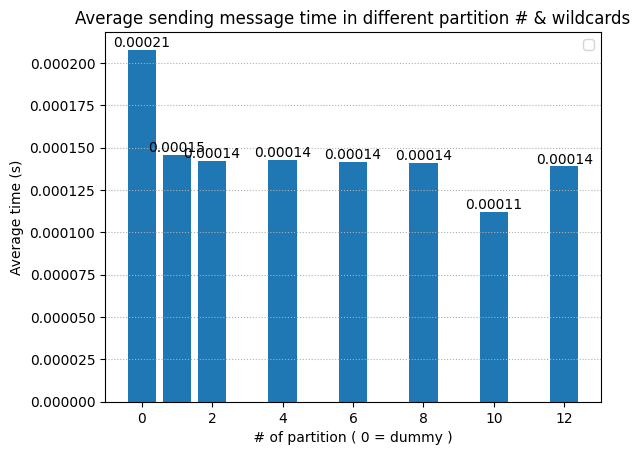

In [42]:
# Prepare data for bar plot
column_averages={}
for ngroup, data in column_time.items():
    column_averages[ngroup] = np.average(column_time[ngroup])

column_averages_dummy = np.average(column_time_dummy_cleaned)

bar_labels = ['dummy', '1group', '2groups', '4groups','8groups','10groups','12groups']
bar_colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green','tab:purple','tab:pink','tab:cyan','tab:olive']

xvalues=[0]
xvalues.append(1)

yvalues=[column_averages_dummy]
yvalues.append(column_averages[1])
for n in range(2,13,2):
    xvalues.append(n)
    yvalues.append(column_averages[n])
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
bars= ax.bar(xvalues,yvalues)
# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')
plt.xlabel(" # of partition ( 0 = dummy ) ")
plt.ylabel("Average time (s)")
plt.legend()
plt.title("Average sending message time in different partition # & wildcards")
plt.grid(axis='y', linestyle=':')
plt.show()

## Box Plot

['dummy', 1, 2, 4, 6, 8, 10, 12]


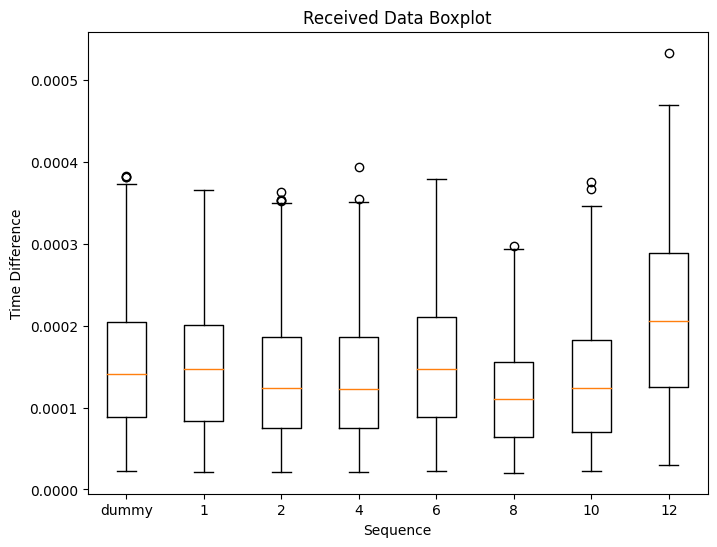

In [60]:
minlength = min(len(data) for data in column_time.values())


column_time[0]=column_time_dummy_cleaned
#need to allineate all data
for ngroup, data in column_time.items():
    if len(data) > minlength:
        column_time[ngroup] = column_time[ngroup][:minlength]
labels=["dummy"] + sequence
print(labels)
plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time.values(),data=column_time.keys(),labels=labels)
plt.title("Received Data Boxplot")
plt.xlabel("Sequence")
plt.ylabel("Time Difference")

save=base_dir.split('/')[1:-1]
plt.savefig(f"results/boxplot_{save[0]}_{save[1]}.png")

plt.show()

